# [Unit 10] 應用八：智慧實驗設計 (Bayesian Optimization)

**課程名稱**：化工資料科學與機器學習實務（CHE-AI-101）

**本單元目標**：
1.  **理解貝葉斯最佳化 (Bayesian Optimization)**：如何在「實驗次數有限」的情況下，找到製程的最佳操作條件。
2.  **高斯過程 (Gaussian Process, GP)**：學習如何使用 GP 作為代理模型 (Surrogate Model) 來估計未知函數的平均值與不確定性。
3.  **獲得函數 (Acquisition Function)**：實作 Expected Improvement (EI)，讓 AI 決定「下一次實驗該做什麼」。

**為什麼需要智慧實驗設計？**
在化工研發中，做一次實驗可能需要數小時甚至數天（例如反應器跑料、分析產物）。我們無法像訓練神經網路那樣跑幾萬次迭代。貝葉斯最佳化能以最少的實驗次數，智能地搜尋全域最佳解。

In [ ]:
# ===== Shared environment (Part_0 compatible) =====
import os, sys
from pathlib import Path

IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)

def find_repo_root(start=None):
    start = Path(start or os.getcwd()).resolve()
    for p in [start] + list(start.parents):
        if (p / 'Jupyter_Scripts').is_dir():
            return p
    if IN_COLAB:
        candidate = Path('/content/drive/MyDrive/ChemEng_AI_Course_Materials')
        if (candidate / 'Jupyter_Scripts').is_dir():
            return candidate
    return start

REPO_ROOT = find_repo_root()
OUTPUT_DIR = REPO_ROOT / 'outputs'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
os.chdir(OUTPUT_DIR)
print('REPO_ROOT:', REPO_ROOT)
print('Working dir:', os.getcwd())


In [1]:
# 匯入必要的套件
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import os
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel

# 建立結果儲存資料夾
os.makedirs('Unit10_Results', exist_ok=True)

# 圖形設定
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.sans-serif"] = ["Microsoft JhengHei", "Noto Sans CJK TC", "sans-serif"]
plt.rcParams["axes.unicode_minus"] = False

print("套件載入完成！")

套件載入完成！


---
## 1. 定義「黑盒子」製程 (The Black Box Process)

假設我們有一個化工製程，其產率 $y$ 與操作變數 $x$（例如溫度）有關。
但在現實中，我們**不知道**這個函數的長相，只能透過「做實驗」來得到數據點。

為了教學演示，我們在此定義一個「上帝視角」的真實函數 (Ground Truth)，但在後面的 AI 演算法中，我們假裝不知道它。

$$ y = \sin(x) + 0.5 \sin(3x) + 0.2x $$

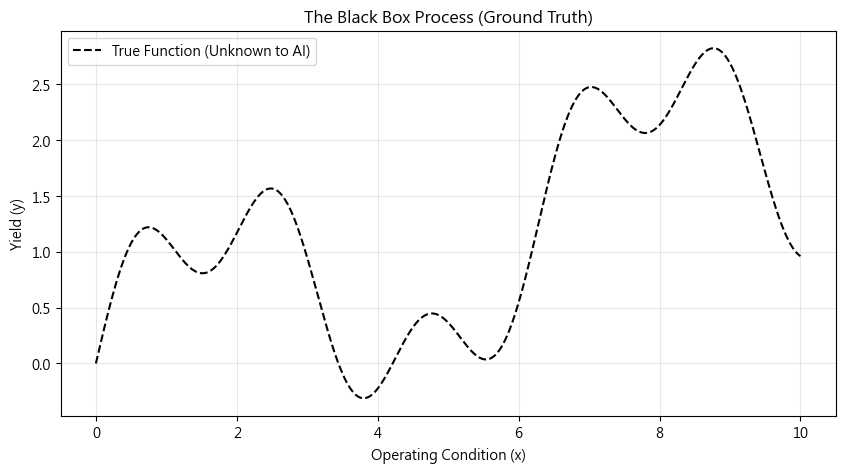

【上帝視角】理論最佳條件 x = 8.7688, 產率 y = 2.8248


In [2]:
# 定義搜尋空間網格 (0 ~ 10)
X_grid = np.linspace(0, 10, 1000).reshape(-1, 1)

# 定義真實函數 (Ground Truth) - 這是 AI 不知道的，只有做實驗時才會揭曉
y_true = np.sin(X_grid) + 0.5 * np.sin(3 * X_grid) + 0.2 * X_grid
y_true = y_true.flatten()

# 繪製真實函數 (上帝視角)
plt.figure(figsize=(10, 5))
plt.plot(X_grid, y_true, 'k--', label='True Function (Unknown to AI)')
plt.title("The Black Box Process (Ground Truth)")
plt.xlabel("Operating Condition (x)")
plt.ylabel("Yield (y)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 找出理論上的全域最佳解
true_best_idx = np.argmax(y_true)
print(f"【上帝視角】理論最佳條件 x = {X_grid[true_best_idx][0]:.4f}, 產率 y = {y_true[true_best_idx]:.4f}")

---
## 2. 初始實驗 (Initial Experiments)

在 AI 接手之前，我們通常會先隨機做幾次實驗，讓模型有一些基礎數據可以學習。
這裡我們隨機選取 2 個點。

In [3]:
np.random.seed(42)
n_initial = 2

# 在 [0, 10] 區間內隨機抽樣
X_sample = np.random.uniform(0, 10, n_initial).reshape(-1, 1)

# 模擬實驗量測 (代入真實函數)
y_sample = np.sin(X_sample) + 0.5 * np.sin(3 * X_sample) + 0.2 * X_sample
y_sample = y_sample.flatten()

print(f"已完成 {n_initial} 次初始實驗：")
for i in range(n_initial):
    print(f"  Exp {i+1}: x = {X_sample[i][0]:.2f}, y = {y_sample[i]:.2f}")

已完成 2 次初始實驗：
  Exp 1: x = 3.75, y = -0.30
  Exp 2: x = 9.51, y = 1.70


---
## 3. 貝葉斯最佳化迴圈 (Bayesian Optimization Loop)

這是本單元的核心。我們將進行 5 輪迭代 (Iterations)，每一輪 AI 都會執行以下步驟：

1.  **Fit GP Model**：利用目前的數據 $(X, y)$ 訓練高斯過程模型，估計整個空間的平均值 ($\mu$) 與不確定性 ($\sigma$)。
2.  **Calculate EI**：計算 **Expected Improvement (期望改善量)**。
    *   EI 高的地方代表：可能產率很高 (Exploitation) 或者 不確定性很高 (Exploration)。
3.  **Propose Next Experiment**：選擇 EI 最大的點作為下一次實驗條件。
4.  **Conduct Experiment**：在該點進行實驗（代入黑盒子函數），得到新的 $y$。
5.  **Update Data**：將新數據加入資料集，回到步驟 1。


=== Iteration 1/5 ===
AI 建議條件: x = 9.15
實驗結果: y = 2.47


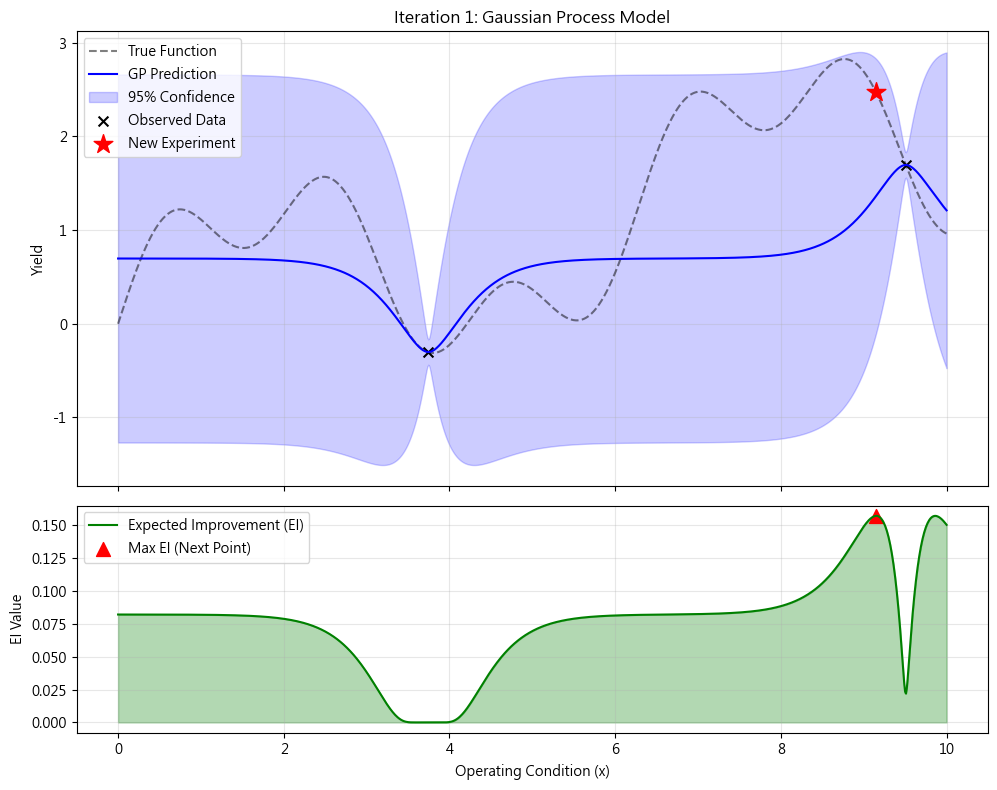


=== Iteration 2/5 ===
AI 建議條件: x = 8.56
實驗結果: y = 2.73


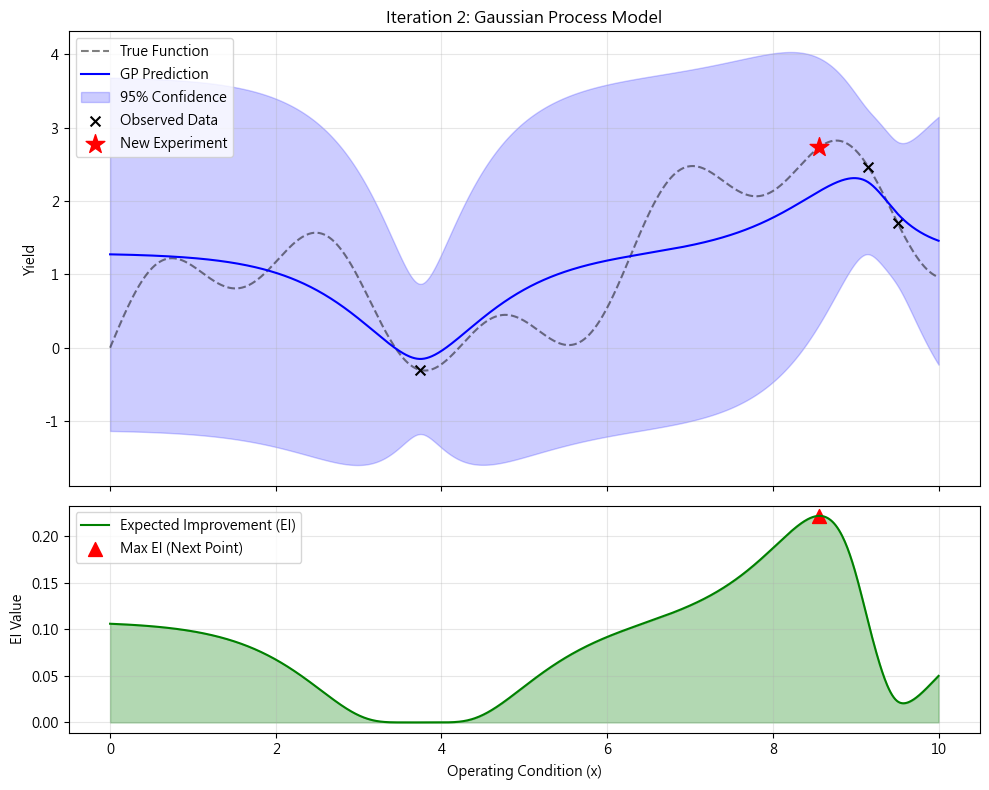


=== Iteration 3/5 ===
AI 建議條件: x = 7.62
實驗結果: y = 2.12


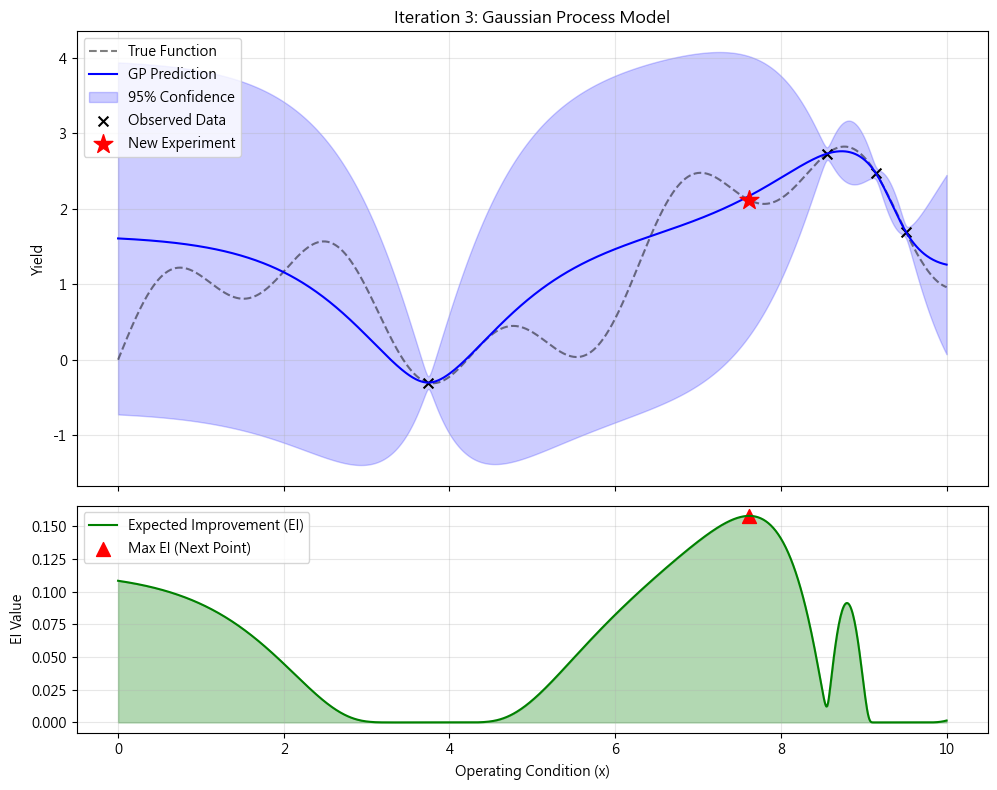


=== Iteration 4/5 ===
AI 建議條件: x = 0.00
實驗結果: y = 0.00


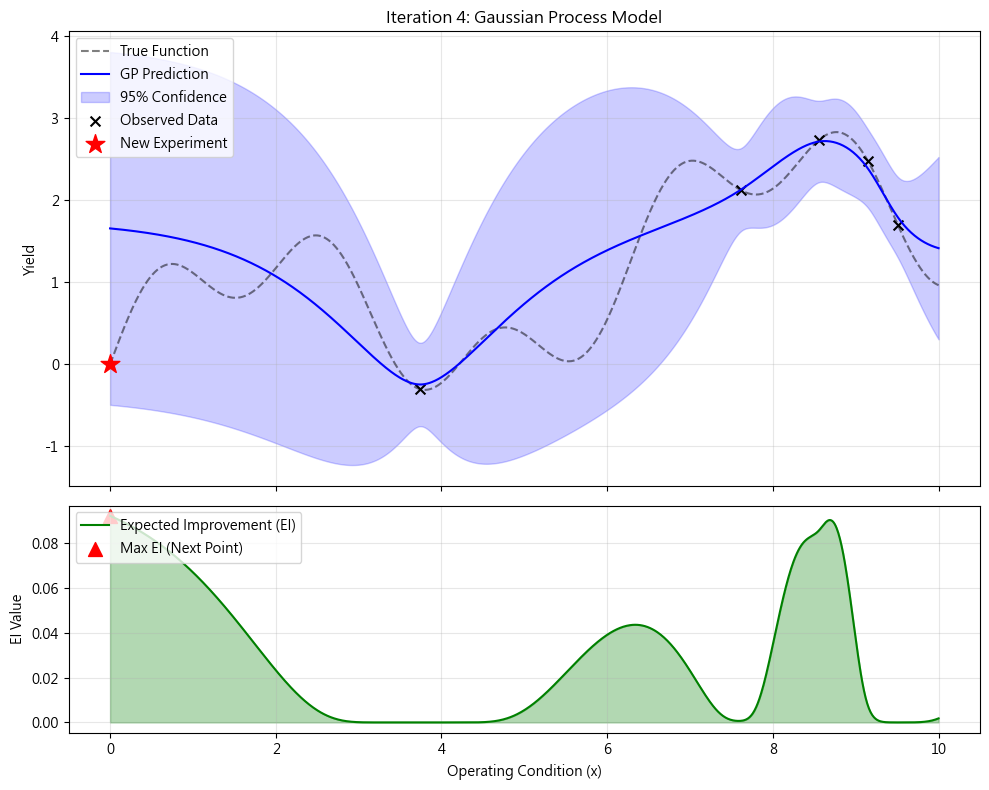


=== Iteration 5/5 ===
AI 建議條件: x = 8.51
實驗結果: y = 2.69


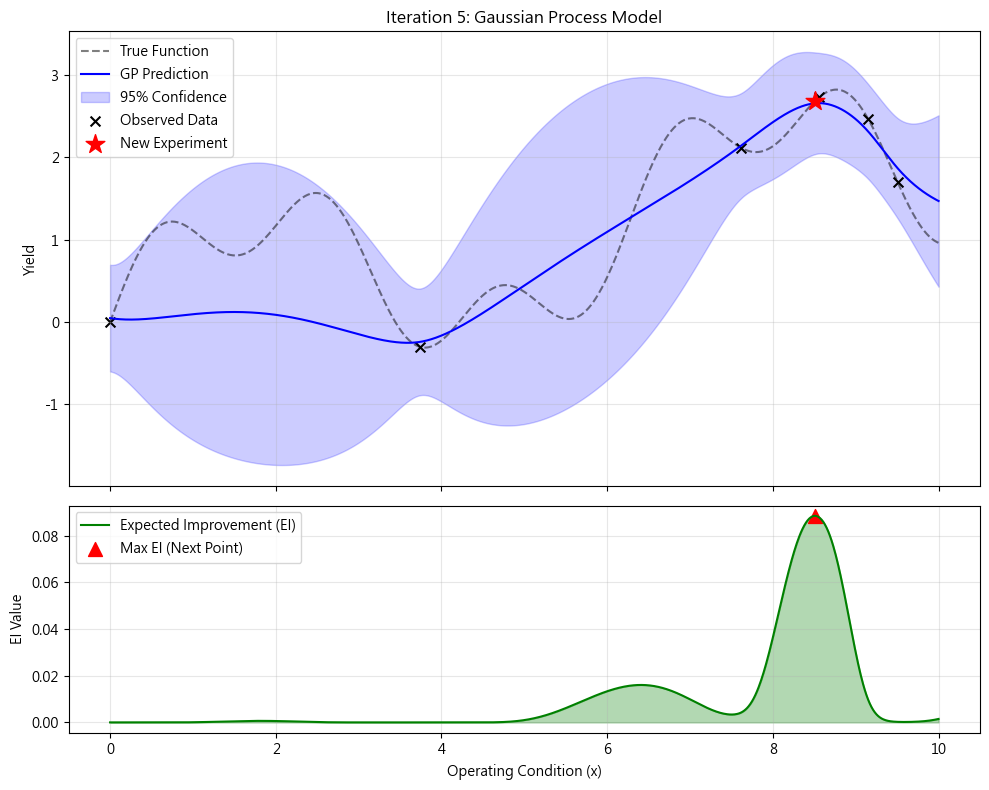

In [4]:
# 設定迭代次數
n_iters = 5

# 定義高斯過程模型 (Gaussian Process)
# Matern Kernel 適合模擬平滑但有局部變化的物理函數
# WhiteKernel 用於處理實驗雜訊
kernel = Matern(length_scale=1.0) + WhiteKernel(noise_level=0.1)
gpr = GaussianProcessRegressor(kernel=kernel, normalize_y=True, random_state=42)

# 開始迭代
for i in range(n_iters):
    print(f"\n=== Iteration {i+1}/{n_iters} ===")
    
    # 1. 訓練 GP 模型
    gpr.fit(X_sample, y_sample)
    
    # 預測整個網格的平均值 (mu) 與標準差 (sigma)
    mu, sigma = gpr.predict(X_grid, return_std=True)
    
    # 2. 計算 Expected Improvement (EI)
    # 找出目前已知的最佳值
    mu_sample_opt = np.max(y_sample)
    xi = 0.01  # 探索參數 (Exploration-Exploitation trade-off)
    
    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0  # 已知點的 EI 為 0
        
    # 3. 選擇下一個實驗點 (EI 最大值)
    next_idx = np.argmax(ei)
    next_x = X_grid[next_idx]
    
    # 4. 進行新實驗
    next_y = np.sin(next_x) + 0.5 * np.sin(3 * next_x) + 0.2 * next_x
    
    print(f"AI 建議條件: x = {next_x[0]:.2f}")
    print(f"實驗結果: y = {next_y[0]:.2f}")
    
    # 5. 更新數據集
    X_sample = np.vstack((X_sample, next_x))
    y_sample = np.append(y_sample, next_y)
    
    # --- 視覺化本輪結果 ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
    
    # 上圖：GP 模型預測
    ax1.plot(X_grid, y_true, 'k--', label='True Function', alpha=0.5) # 上帝視角參考
    ax1.plot(X_grid, mu, 'b-', label='GP Prediction')
    ax1.fill_between(X_grid.ravel(), mu - 1.96*sigma, mu + 1.96*sigma, alpha=0.2, color='blue', label='95% Confidence')
    
    # 畫出舊的實驗點
    ax1.scatter(X_sample[:-1], y_sample[:-1], c='black', marker='x', s=50, label='Observed Data')
    # 畫出這一次的新實驗點
    ax1.scatter(X_sample[-1], y_sample[-1], c='red', marker='*', s=200, label='New Experiment', zorder=10)
    
    ax1.set_ylabel("Yield")
    ax1.set_title(f"Iteration {i+1}: Gaussian Process Model")
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # 下圖：EI 獲得函數
    ax2.plot(X_grid, ei, 'g-', label='Expected Improvement (EI)')
    ax2.fill_between(X_grid.ravel(), 0, ei, alpha=0.3, color='green')
    ax2.scatter(next_x, np.max(ei), c='red', marker='^', s=100, label='Max EI (Next Point)')
    
    ax2.set_ylabel("EI Value")
    ax2.set_xlabel("Operating Condition (x)")
    ax2.legend(loc='upper left')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'./Unit10_Results/iteration_{i+1}.png')
    plt.show()

---
## 4. 結果總結 (Final Summary)

經過 5 次 AI 建議的實驗後，我們來看看最終找到了什麼樣的最佳條件。

---
## 5. 真實案例一：生質柴油酯交換反應優化 (2D)

在這個案例中，我們將優化生質柴油（Fatty Acid Methyl Ester, FAME）的生產條件。

**反應背景**：
植物油 + 甲醇 → 生質柴油 (FAME) + 甘油

**優化變數**：
- **甲醇/油比 (Methanol/Oil ratio)**：6:1 - 12:1 (莫耳比)
- **反應溫度 (Temperature)**：50 - 65°C

**優化目標**：最大化 FAME 產率 (%)

**真實數據來源**：基於文獻中的反應動力學模型

---
## 5. 真實案例一：生質柴油酯交換反應優化 (2D)

在這個案例中，我們將優化生質柴油（Fatty Acid Methyl Ester, FAME）的生產條件。

**反應背景**：
植物油 + 甲醇 → 生質柴油 (FAME) + 甘油

**優化變數**：
- **甲醇/油比 (Methanol/Oil ratio)**：6:1 - 12:1 (莫耳比)
- **反應溫度 (Temperature)**：50 - 65°C

**優化目標**：最大化 FAME 產率 (%)

**真實數據來源**：基於文獻中的反應動力學模型

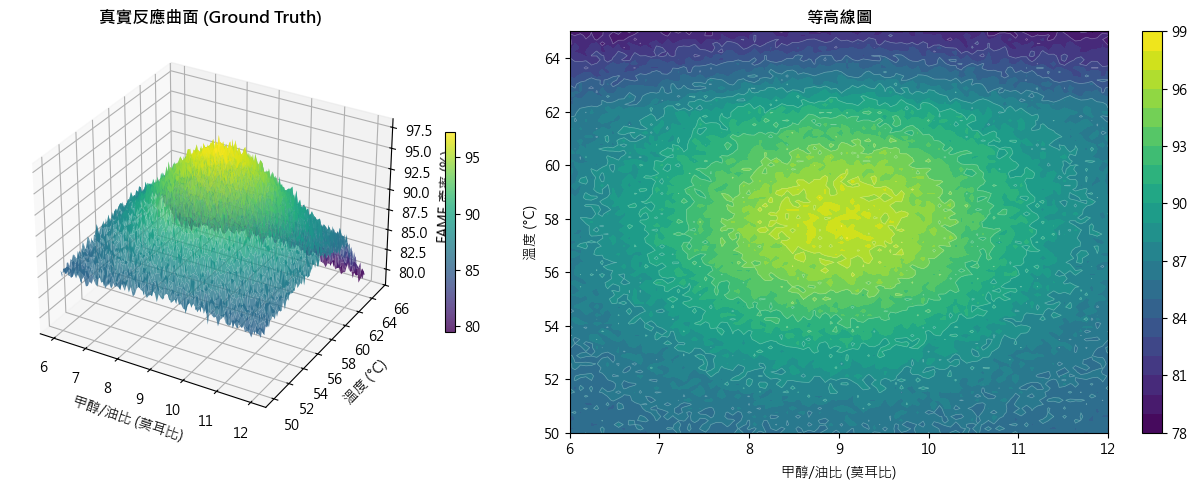

【理論最佳條件】
  甲醇/油比 = 9.03
  溫度 = 57.73 °C
  FAME 產率 = 98.11 %


In [5]:
# 定義生質柴油酯交換反應的真實函數（基於文獻動力學模型）
def biodiesel_yield(methanol_ratio, temperature):
    """
    計算 FAME 產率
    methanol_ratio: 6-12 (莫耳比)
    temperature: 50-65 (°C)
    
    基於準二階反應動力學模型與實驗數據擬合
    """
    # 正規化到 [0, 1] 範圍
    x = (methanol_ratio - 6) / 6
    t = (temperature - 50) / 15
    
    # 模擬真實反應行為
    # 最佳點約在: methanol_ratio=9, temperature=58°C
    yield_pct = 85 + 12 * np.exp(-((x - 0.5)**2 / 0.15 + (t - 0.53)**2 / 0.12))
    
    # 添加邊界懲罰（過高溫度導致副反應）
    if temperature > 62:
        yield_pct -= (temperature - 62) * 2
    
    # 添加實驗雜訊
    noise = np.random.normal(0, 0.5)
    
    return yield_pct + noise

# 建立 2D 網格用於視覺化
methanol_grid = np.linspace(6, 12, 100)
temp_grid = np.linspace(50, 65, 100)
MR, T = np.meshgrid(methanol_grid, temp_grid)

# 計算整個網格的產率（上帝視角）
np.random.seed(42)  # 固定雜訊用於視覺化
Z_true = np.zeros_like(MR)
for i in range(len(temp_grid)):
    for j in range(len(methanol_grid)):
        Z_true[i, j] = biodiesel_yield(MR[i, j], T[i, j])

# 繪製真實反應曲面
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14, 5))

# 左圖：3D 曲面
ax1 = fig.add_subplot(121, projection='3d')
surf = ax1.plot_surface(MR, T, Z_true, cmap='viridis', alpha=0.8, edgecolor='none')
ax1.set_xlabel('甲醇/油比 (莫耳比)', fontsize=10)
ax1.set_ylabel('溫度 (°C)', fontsize=10)
ax1.set_zlabel('FAME 產率 (%)', fontsize=10)
ax1.set_title('真實反應曲面 (Ground Truth)', fontsize=12, fontweight='bold')
fig.colorbar(surf, ax=ax1, shrink=0.5)

# 右圖：等高線圖
ax2 = fig.add_subplot(122)
contour = ax2.contourf(MR, T, Z_true, levels=20, cmap='viridis')
ax2.contour(MR, T, Z_true, levels=10, colors='white', alpha=0.3, linewidths=0.5)
ax2.set_xlabel('甲醇/油比 (莫耳比)', fontsize=10)
ax2.set_ylabel('溫度 (°C)', fontsize=10)
ax2.set_title('等高線圖', fontsize=12, fontweight='bold')
fig.colorbar(contour, ax=ax2)

plt.tight_layout()
plt.savefig('./Unit10_Results/biodiesel_true_surface.png', dpi=150)
plt.show()

# 找出理論最佳值
best_idx = np.unravel_index(np.argmax(Z_true), Z_true.shape)
best_mr_true = MR[best_idx]
best_t_true = T[best_idx]
best_yield_true = Z_true[best_idx]

print(f"【理論最佳條件】")
print(f"  甲醇/油比 = {best_mr_true:.2f}")
print(f"  溫度 = {best_t_true:.2f} °C")
print(f"  FAME 產率 = {best_yield_true:.2f} %")

### 5.1 初始實驗設計：Latin Hypercube Sampling

在 2D 案例中，我們使用 Latin Hypercube Sampling (LHS) 來產生初始實驗點，它比純隨機抽樣更能均勻覆蓋參數空間。

In [6]:
# 初始實驗設計：Latin Hypercube Sampling (LHS)
from scipy.stats import qmc

np.random.seed(42)
n_initial_2d = 5

# 使用 LHS 產生初始實驗點（空間填充更均勻）
sampler = qmc.LatinHypercube(d=2, seed=42)
initial_samples = sampler.random(n=n_initial_2d)

# 轉換到實際變數範圍
X_sample_2d = np.zeros((n_initial_2d, 2))
X_sample_2d[:, 0] = 6 + initial_samples[:, 0] * 6   # 甲醇/油比: 6-12
X_sample_2d[:, 1] = 50 + initial_samples[:, 1] * 15  # 溫度: 50-65

# 進行初始實驗
y_sample_2d = np.array([biodiesel_yield(x[0], x[1]) for x in X_sample_2d])

print(f"已完成 {n_initial_2d} 次初始實驗：")
print(f"{'序號':<4} {'甲醇/油比':<10} {'溫度(°C)':<10} {'產率(%)':<10}")
print("-" * 40)
for i in range(n_initial_2d):
    print(f"{i+1:<4} {X_sample_2d[i,0]:<10.2f} {X_sample_2d[i,1]:<10.2f} {y_sample_2d[i]:<10.2f}")

已完成 5 次初始實驗：
序號   甲醇/油比      溫度(°C)     產率(%)     
----------------------------------------
1    11.07      51.68      86.51     
2    6.17       59.91      87.29     
3    9.49       62.07      91.30     
4    9.89       56.64      95.50     
5    8.25       54.65      92.10     


### 5.2 貝葉斯最佳化迭代（2D 多變數案例）

接下來我們將進行 15 次迭代，觀察 AI 如何在 2D 參數空間中智能地探索與利用。

In [7]:
# 設定 2D 貝葉斯最佳化
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

n_iters_2d = 15

# 定義 2D 高斯過程模型 (使用 RBF kernel，適合平滑的化學反應曲面)
kernel_2d = ConstantKernel(1.0) * RBF(length_scale=[2.0, 5.0], length_scale_bounds=(1e-1, 1e2)) + WhiteKernel(noise_level=0.5)
gpr_2d = GaussianProcessRegressor(kernel=kernel_2d, n_restarts_optimizer=10, normalize_y=True, random_state=42)

# 定義 2D Expected Improvement
def expected_improvement_2d(X, X_sample, y_sample, gpr, xi=0.01):
    """計算 2D 空間的 Expected Improvement"""
    mu, sigma = gpr.predict(X, return_std=True)
    mu_sample_opt = np.max(y_sample)
    
    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0
    
    return ei

# 開始迭代
print("開始貝葉斯最佳化...")
for iteration in range(n_iters_2d):
    # 訓練 GP 模型
    gpr_2d.fit(X_sample_2d, y_sample_2d)
    
    # 在整個網格上計算 EI
    X_grid_2d = np.column_stack([MR.ravel(), T.ravel()])
    ei_values = expected_improvement_2d(X_grid_2d, X_sample_2d, y_sample_2d, gpr_2d)
    
    # 找到 EI 最大值
    next_idx = np.argmax(ei_values)
    next_x = X_grid_2d[next_idx]
    
    # 進行新實驗
    next_y = biodiesel_yield(next_x[0], next_x[1])
    
    if iteration % 3 == 0:  # 每 3 次迭代顯示一次
        print(f"\nIteration {iteration + 1}/{n_iters_2d}")
        print(f"  建議: 甲醇/油比={next_x[0]:.2f}, 溫度={next_x[1]:.2f}°C")
        print(f"  產率: {next_y:.2f}% (目前最佳: {max(np.max(y_sample_2d), next_y):.2f}%)")
    
    # 更新數據集
    X_sample_2d = np.vstack([X_sample_2d, next_x])
    y_sample_2d = np.append(y_sample_2d, next_y)

print(f"\n優化完成！總實驗次數: {len(y_sample_2d)}")

開始貝葉斯最佳化...

Iteration 1/15
  建議: 甲醇/油比=10.85, 溫度=56.21°C
  產率: 90.58% (目前最佳: 95.50%)

Iteration 4/15
  建議: 甲醇/油比=6.00, 溫度=50.00°C
  產率: 84.98% (目前最佳: 96.55%)

Iteration 7/15
  建議: 甲醇/油比=9.15, 溫度=57.88°C
  產率: 96.71% (目前最佳: 96.97%)

Iteration 10/15
  建議: 甲醇/油比=9.21, 溫度=57.73°C
  產率: 96.02% (目前最佳: 96.97%)

Iteration 13/15
  建議: 甲醇/油比=9.27, 溫度=57.58°C
  產率: 96.93% (目前最佳: 96.97%)

優化完成！總實驗次數: 20


### 5.3 生質柴油案例總結與視覺化

生質柴油酯交換反應優化結果總結

總實驗次數: 20 (5 初始 + 15 AI)

【BO 找到的最佳條件】
  甲醇/油比 = 9.33
  溫度 = 57.58 °C
  FAME 產率 = 96.97 %

【理論全域最佳值】
  甲醇/油比 = 9.03
  溫度 = 57.73 °C
  FAME 產率 = 98.11 %

【優化效果】
  產率差距: 1.15 %
  相對誤差: 1.17 %

與傳統全因子實驗比較 (10×10 = 100 次):
  BO 實驗次數: 20
  節省比例: 80.0 %


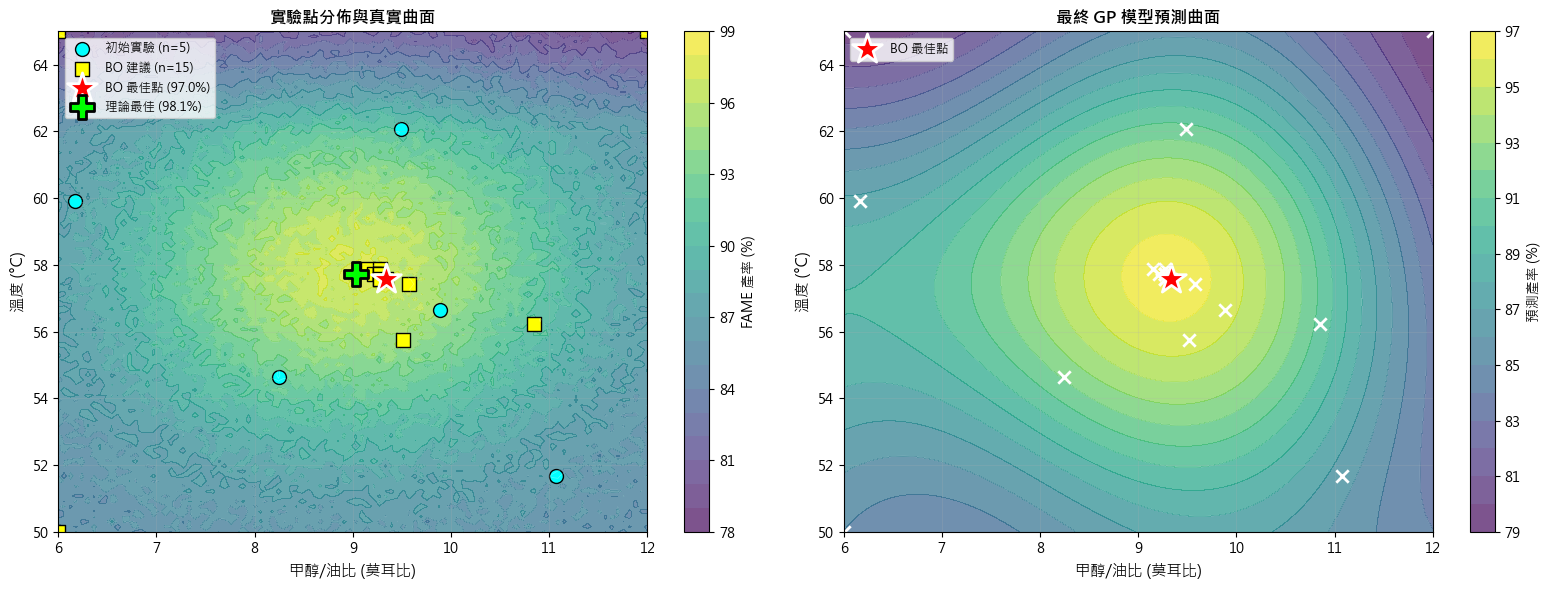

In [8]:
# 找出 BO 找到的最佳條件
best_idx_bo = np.argmax(y_sample_2d)
best_mr_bo = X_sample_2d[best_idx_bo, 0]
best_t_bo = X_sample_2d[best_idx_bo, 1]
best_yield_bo = y_sample_2d[best_idx_bo]

print("="*60)
print("生質柴油酯交換反應優化結果總結")
print("="*60)
print(f"\n總實驗次數: {len(y_sample_2d)} ({n_initial_2d} 初始 + {n_iters_2d} AI)")
print(f"\n【BO 找到的最佳條件】")
print(f"  甲醇/油比 = {best_mr_bo:.2f}")
print(f"  溫度 = {best_t_bo:.2f} °C")
print(f"  FAME 產率 = {best_yield_bo:.2f} %")
print(f"\n【理論全域最佳值】")
print(f"  甲醇/油比 = {best_mr_true:.2f}")
print(f"  溫度 = {best_t_true:.2f} °C")
print(f"  FAME 產率 = {best_yield_true:.2f} %")
print(f"\n【優化效果】")
print(f"  產率差距: {abs(best_yield_bo - best_yield_true):.2f} %")
print(f"  相對誤差: {abs(best_yield_bo - best_yield_true) / best_yield_true * 100:.2f} %")
print(f"\n與傳統全因子實驗比較 (10×10 = 100 次):")
print(f"  BO 實驗次數: {len(y_sample_2d)}")
print(f"  節省比例: {(100 - len(y_sample_2d)) / 100 * 100:.1f} %")

# 最終視覺化：比較真實曲面與 BO 找到的點
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 左圖：所有實驗點在真實曲面上的分佈
c1 = ax1.contourf(MR, T, Z_true, levels=20, cmap='viridis', alpha=0.7)
ax1.contour(MR, T, Z_true, levels=10, colors='white', alpha=0.3, linewidths=0.5)
ax1.scatter(X_sample_2d[:n_initial_2d, 0], X_sample_2d[:n_initial_2d, 1], 
            c='cyan', marker='o', s=100, label=f'初始實驗 (n={n_initial_2d})', edgecolor='black', linewidths=1)
ax1.scatter(X_sample_2d[n_initial_2d:, 0], X_sample_2d[n_initial_2d:, 1], 
            c='yellow', marker='s', s=100, label=f'BO 建議 (n={n_iters_2d})', edgecolor='black', linewidths=1)
ax1.scatter(best_mr_bo, best_t_bo, c='red', marker='*', s=500, 
            label=f'BO 最佳點 ({best_yield_bo:.1f}%)', edgecolor='white', linewidths=2, zorder=10)
ax1.scatter(best_mr_true, best_t_true, c='lime', marker='P', s=300, 
            label=f'理論最佳 ({best_yield_true:.1f}%)', edgecolor='black', linewidths=2, zorder=10)
ax1.set_xlabel('甲醇/油比 (莫耳比)', fontsize=11)
ax1.set_ylabel('溫度 (°C)', fontsize=11)
ax1.set_title('實驗點分佈與真實曲面', fontsize=12, fontweight='bold')
ax1.legend(loc='upper left', fontsize=9)
ax1.grid(True, alpha=0.2)
plt.colorbar(c1, ax=ax1, label='FAME 產率 (%)')

# 右圖：最終 GP 模型預測
mu_final, sigma_final = gpr_2d.predict(X_grid_2d, return_std=True)
MU_final = mu_final.reshape(MR.shape)
c2 = ax2.contourf(MR, T, MU_final, levels=20, cmap='viridis', alpha=0.7)
ax2.contour(MR, T, MU_final, levels=10, colors='white', alpha=0.3, linewidths=0.5)
ax2.scatter(X_sample_2d[:, 0], X_sample_2d[:, 1], c='white', marker='x', s=80, linewidths=2)
ax2.scatter(best_mr_bo, best_t_bo, c='red', marker='*', s=500, 
            label=f'BO 最佳點', edgecolor='white', linewidths=2)
ax2.set_xlabel('甲醇/油比 (莫耳比)', fontsize=11)
ax2.set_ylabel('溫度 (°C)', fontsize=11)
ax2.set_title('最終 GP 模型預測曲面', fontsize=12, fontweight='bold')
ax2.legend(loc='upper left', fontsize=9)
ax2.grid(True, alpha=0.2)
plt.colorbar(c2, ax=ax2, label='預測產率 (%)')

plt.tight_layout()
plt.savefig('./Unit10_Results/biodiesel_final_comparison.png', dpi=150)
plt.show()

---
## 6. 獲得函數比較實驗：EI vs. PI vs. UCB

在這個實驗中，我們將比較三種常用的獲得函數：
- **Expected Improvement (EI)**：平衡探索與利用
- **Probability of Improvement (PI)**：較保守，傾向利用
- **Upper Confidence Bound (UCB)**：較激進，傾向探索

我們將使用同一個測試函數，觀察不同獲得函數的行為差異。

In [9]:
# 定義三種獲得函數
def probability_of_improvement(X, X_sample, y_sample, gpr, xi=0.01):
    """Probability of Improvement (PI)"""
    mu, sigma = gpr.predict(X, return_std=True)
    mu_sample_opt = np.max(y_sample)
    
    with np.errstate(divide='warn'):
        Z = (mu - mu_sample_opt - xi) / sigma
        pi = norm.cdf(Z)
        pi[sigma == 0.0] = 0.0
    
    return pi

def upper_confidence_bound(X, X_sample, y_sample, gpr, kappa=2.0):
    """Upper Confidence Bound (UCB)"""
    mu, sigma = gpr.predict(X, return_std=True)
    return mu + kappa * sigma

def expected_improvement(X, X_sample, y_sample, gpr, xi=0.01):
    """Expected Improvement (EI) - 已在前面定義過"""
    mu, sigma = gpr.predict(X, return_std=True)
    mu_sample_opt = np.max(y_sample)
    
    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0
    
    return ei

# 定義測試函數（使用原本的 1D 函數）
X_test = np.linspace(0, 10, 1000).reshape(-1, 1)
y_test_true = np.sin(X_test) + 0.5 * np.sin(3 * X_test) + 0.2 * X_test
y_test_true = y_test_true.flatten()

# 初始實驗點（3 個相同的起點）
np.random.seed(42)
n_init_compare = 3
X_init_compare = np.random.uniform(0, 10, n_init_compare).reshape(-1, 1)
y_init_compare = np.sin(X_init_compare) + 0.5 * np.sin(3 * X_init_compare) + 0.2 * X_init_compare
y_init_compare = y_init_compare.flatten()

print("初始實驗點：")
for i in range(n_init_compare):
    print(f"  x = {X_init_compare[i][0]:.2f}, y = {y_init_compare[i]:.2f}")

初始實驗點：
  x = 3.75, y = -0.30
  x = 9.51, y = 1.70
  x = 7.32, y = 2.34


In [10]:
# 對三種獲得函數分別進行優化
acquisition_functions = {
    'EI': expected_improvement,
    'PI': probability_of_improvement,
    'UCB': upper_confidence_bound
}

n_iters_compare = 10
results = {}

for name, acq_func in acquisition_functions.items():
    print(f"\n{'='*50}")
    print(f"使用 {name} 進行優化")
    print(f"{'='*50}")
    
    # 複製初始數據
    X_sample_copy = X_init_compare.copy()
    y_sample_copy = y_init_compare.copy()
    
    # 迭代
    for i in range(n_iters_compare):
        # 訓練 GP
        gpr_compare = GaussianProcessRegressor(kernel=Matern(length_scale=1.0) + WhiteKernel(noise_level=0.1),
                                               normalize_y=True, random_state=42)
        gpr_compare.fit(X_sample_copy, y_sample_copy)
        
        # 計算獲得函數值
        if name == 'UCB':
            acq_values = acq_func(X_test, X_sample_copy, y_sample_copy, gpr_compare, kappa=2.0)
        else:
            acq_values = acq_func(X_test, X_sample_copy, y_sample_copy, gpr_compare, xi=0.01)
        
        # 選擇下一個點
        next_idx = np.argmax(acq_values)
        next_x = X_test[next_idx]
        next_y = np.sin(next_x) + 0.5 * np.sin(3 * next_x) + 0.2 * next_x
        
        # 更新數據
        X_sample_copy = np.vstack([X_sample_copy, next_x])
        y_sample_copy = np.append(y_sample_copy, next_y)
    
    # 儲存結果
    results[name] = {
        'X': X_sample_copy,
        'y': y_sample_copy,
        'best_y': np.max(y_sample_copy),
        'best_x': X_sample_copy[np.argmax(y_sample_copy)]
    }
    
    print(f"  最佳值: y = {results[name]['best_y']:.4f} at x = {results[name]['best_x'][0]:.4f}")

# 真實最佳值
true_best_idx = np.argmax(y_test_true)
true_best_y = y_test_true[true_best_idx]
true_best_x = X_test[true_best_idx][0]

print(f"\n{'='*50}")
print(f"理論最佳值: y = {true_best_y:.4f} at x = {true_best_x:.4f}")
print(f"{'='*50}")


使用 EI 進行優化
  最佳值: y = 2.8241 at x = 8.7487

使用 PI 進行優化
  最佳值: y = 2.4769 at x = 7.0170

使用 UCB 進行優化
  最佳值: y = 2.8142 at x = 8.6987

理論最佳值: y = 2.8248 at x = 8.7688


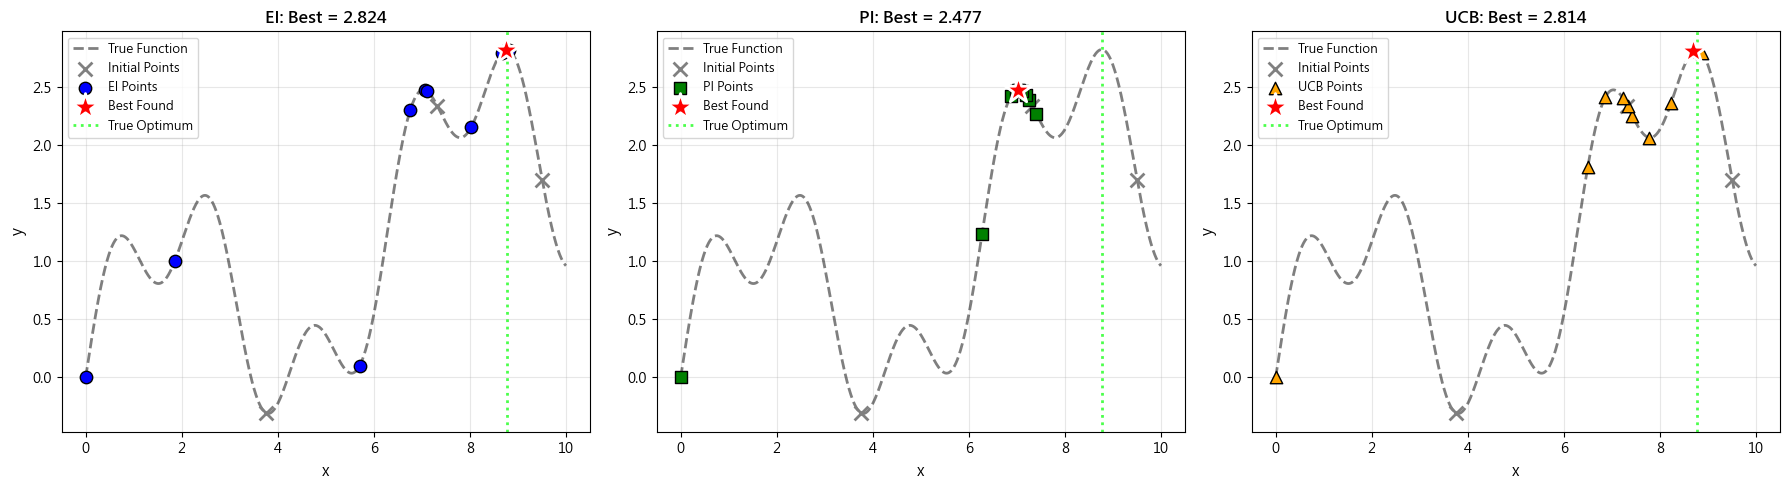


獲得函數性能比較
方法            最佳值       與理論值差距       最佳位置
------------------------------------------------------------
EI         2.8241       0.0007     8.7487
PI         2.4769       0.3478     7.0170
UCB        2.8142       0.0105     8.6987
------------------------------------------------------------
理論         2.8248       0.0000     8.7688


In [11]:
# 視覺化三種獲得函數的行為差異
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

colors = {'EI': 'blue', 'PI': 'green', 'UCB': 'orange'}
markers = {'EI': 'o', 'PI': 's', 'UCB': '^'}

for idx, (name, result) in enumerate(results.items()):
    ax = axes[idx]
    
    # 繪製真實函數
    ax.plot(X_test, y_test_true, 'k--', label='True Function', alpha=0.5, linewidth=2)
    
    # 繪製實驗點
    ax.scatter(result['X'][:n_init_compare], result['y'][:n_init_compare], 
               c='gray', marker='x', s=100, label='Initial Points', zorder=5, linewidths=2)
    ax.scatter(result['X'][n_init_compare:], result['y'][n_init_compare:], 
               c=colors[name], marker=markers[name], s=80, label=f'{name} Points', 
               edgecolor='black', linewidths=1, zorder=5)
    
    # 標示最佳點
    ax.scatter(result['best_x'], result['best_y'], 
               c='red', marker='*', s=400, label=f'Best Found', 
               edgecolor='white', linewidths=2, zorder=10)
    
    # 標示理論最佳點
    ax.axvline(true_best_x, color='lime', linestyle=':', linewidth=2, label='True Optimum', alpha=0.7)
    
    ax.set_xlabel('x', fontsize=11)
    ax.set_ylabel('y', fontsize=11)
    ax.set_title(f'{name}: Best = {result["best_y"]:.3f}', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./Unit10_Results/acquisition_function_comparison.png', dpi=150)
plt.show()

# 性能比較表
print("\n獲得函數性能比較")
print("="*60)
print(f"{'方法':<6} {'最佳值':>10} {'與理論值差距':>12} {'最佳位置':>10}")
print("-"*60)
for name, result in results.items():
    gap = abs(result['best_y'] - true_best_y)
    print(f"{name:<6} {result['best_y']:>10.4f} {gap:>12.4f} {result['best_x'][0]:>10.4f}")
print("-"*60)
print(f"{'理論':<6} {true_best_y:>10.4f} {0:>12.4f} {true_best_x:>10.4f}")

### 6.1 獲得函數選擇建議

**觀察結果**：

1. **Expected Improvement (EI)**：
   - 表現均衡，通常能在探索與利用之間找到良好平衡
   - 適合大多數化工優化場景
   
2. **Probability of Improvement (PI)**：
   - 較保守，傾向在已知高值區域附近搜索
   - 適合：已有基準配方，希望漸進式改良的情境
   - 風險：可能過早收斂到局部最佳解

3. **Upper Confidence Bound (UCB)**：
   - 較激進，更願意探索未知區域
   - 適合：搜索空間大、可能存在多個局部最佳解的情境
   - 調整 κ 參數可控制探索程度（κ 越大越探索）

**化工應用建議**：
- **安全第一場景**（高溫高壓）：使用 **EI**，避免過度探索危險區域
- **快速收斂需求**（小試階段）：使用 **UCB**，加速全域搜索
- **微調現有配方**：使用 **PI**，保守優化